In [1]:
"""
Multi-Channel Speech Presence Probability
==============

----------


.. [1] M. Souden, J. Chen, J. Benesty and S. Affes, "Gaussian Model-Based Multichannel Speech Presence Probability,"
    in IEEE Transactions on Audio, Speech, and Language Processing, vol. 18, no. 5, pp. 1072-1077, July 2010,
    doi: 10.1109/TASL.2009.2035150.
   [2] Bagheri, S., Giacobello, D. (2019) Exploiting Multi-Channel Speech Presence Probability in Parametric
    Multi-Channel Wiener Filter. Proc. Interspeech 2019, 101-105, DOI: 10.21437/Interspeech.2019-2665

"""

import os

import numpy as np
from scipy.signal import convolve
import soundfile as sf
from pesq import pesq
from pystoi.stoi import stoi
import IPython.display as ipd

from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.ArraySim import ArraySim

from DistantSpeech.noise_estimation.mcra import NoiseEstimationMCRA
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, load_wav, save_audio, load_pcm

import numpy as np
import librosa
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.MicArray import MicArray, ArraySim
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.MicArray import MicArray, compute_tau
from DistantSpeech.noise_estimation.mcra import NoiseEstimationMCRA
from DistantSpeech.noise_estimation.mcra2 import MCRA2
from DistantSpeech.noise_estimation.mcspp import McSpp

The RT60 is 82 ms
(6, 121515)
(257, 514, 6)
(257, 474, 6)


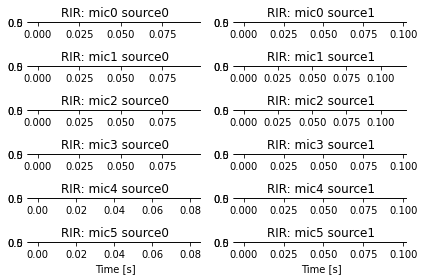

In [2]:


sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.1
sound_speed = 343
look_direction = 30

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550.wav")
# signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office1.wav")
fs = 16000
M = 6
mic_array = MicArray(arrayType="circular", r=mic_diameter/2, M=M)
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
array_data, premix = mic_array_sim.generate_audio(signal, interference=noise, source_angle=look_direction, interf_angle=270, sir=0, snr=30)
# audiowrite('mix.wav', np.transpose(array_data))
# audiowrite('signal.wav', np.transpose(premix[0, :, :]))
# audiowrite('interf.wav', np.transpose(premix[1, :, :]))

print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
target = transform.stft(np.transpose(premix[0, :M, :]))
Noise = transform.stft(np.transpose(premix[1, :M, :]))
print(Noise.shape)
half_bin = D.shape[0]
frame_num = D.shape[1]
print(D.shape)

(257, 514, 6)
(257, 474, 6)


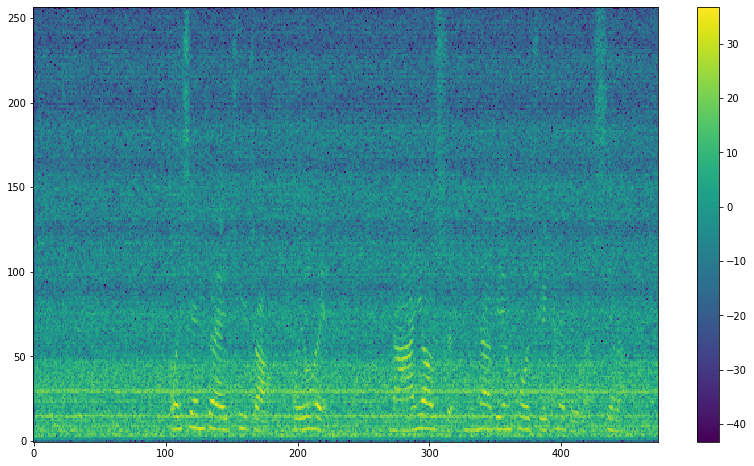

In [3]:

sr = 16000
r = 0.032
c = 343

frameLen = 256
hop = frameLen / 2
overlap = frameLen - hop
nfft = 256
c = 340
r = 0.032
fs = sr

# pampath = '/home/wangwei/work/DistantSpeech/samples/bookself/1'
# # pampath = '/home/wangwei/work/corpus/kws/lanso/record_test/meetingroom/20220106/pcm'
# array_data = load_pcm(pampath)

# wavpath = '/home/wangwei/work/Beamforming-for-speech-enhancement-master/sample_data'
# array_data, _ = load_wav(wavpath)
# array_data = array_data[:M, :]


transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
Noise = transform.stft(np.transpose(premix[1, ...]))

D = D[:, :790, :]
Noise = Noise[:, :790, :]
print(Noise.shape)
Y, _ = transform.magphase(D, 2)
print(Y.shape)
pmesh(librosa.power_to_db(Y[:, :, 0]))
audiowrite('mix.wav', np.transpose(array_data))
audiowrite('target.wav', np.transpose(premix[0, :, :]))
audiowrite('interf.wav', np.transpose(premix[1, :, :]))

In [4]:
channel = M
mcspp = McSpp(nfft=512, channels=channel)
mcspp.mcra.L = 15

p = np.zeros((half_bin, Y.shape[1]))
q = np.zeros((half_bin, Y.shape[1]))

Yout = np.zeros((Y.shape[0], Y.shape[1]), dtype=complex)
w_n = np.zeros((M, half_bin), dtype=complex)

alpha_xx = mcspp.alpha
alpha_vv = mcspp.alpha
Phi_xx_th = np.zeros((M, M, half_bin), dtype=complex)
Phi_vv_th = np.zeros((M, M, half_bin), dtype=complex)

xi_th = np.zeros((half_bin, Y.shape[1])) # theoretical
xi = np.zeros((half_bin, Y.shape[1])) # estimated


for n in range(Y.shape[1]):
    y = D[:, n, :] #[half_bin, M]

    # theoretical PSD
    noise = Noise[:, n, :] # [M, half_bin]
    target_n = target[:, n, :]
    psd_vv_th = np.einsum('ij,il->ijl', noise, noise.conj())
    Phi_vv_th = alpha_vv * Phi_vv_th + (1 - alpha_vv) * (np.transpose(psd_vv_th, (1, 2, 0))) # [M,M,half_bin]

    psd_xx_th = np.einsum('ij,il->ijl', target_n, target_n.conj())
    Phi_xx_th = alpha_xx * Phi_xx_th + (1 - alpha_xx) * (np.transpose(psd_xx_th, (1, 2, 0))) # [M,M,half_bin]
    
    for k in range(mcspp.half_bin):
        Phi_vv_inv_th = np.linalg.inv(Phi_vv_th[:, :, k] + np.eye(M) * 1e-6)
        xi_th[k, n] =  np.trace(np.real(Phi_vv_inv_th @ Phi_xx_th[:, :, k]))

    p[:, n] = mcspp.estimation(y, diag=1e-8)
    xi[:, n] = mcspp.xi
    if n == 180:
        w_n[:] = mcspp.w
    Yout[:, n] = np.sum(y*mcspp.w.conj().T, axis=1)

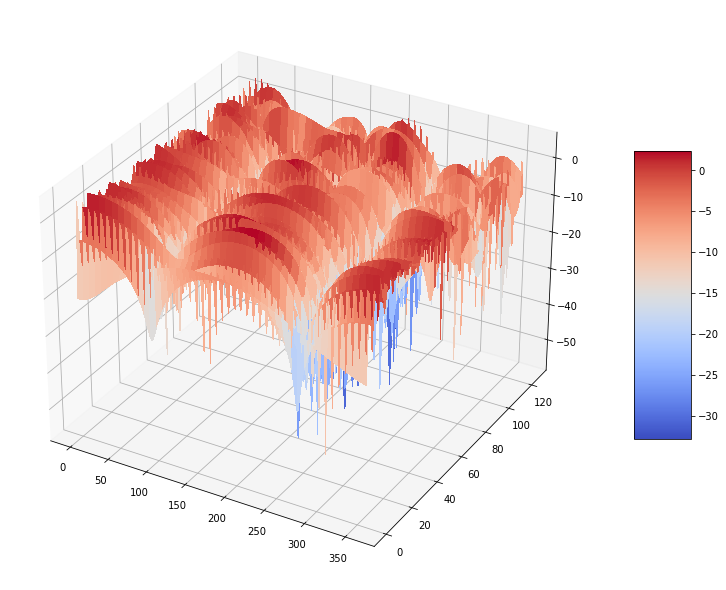

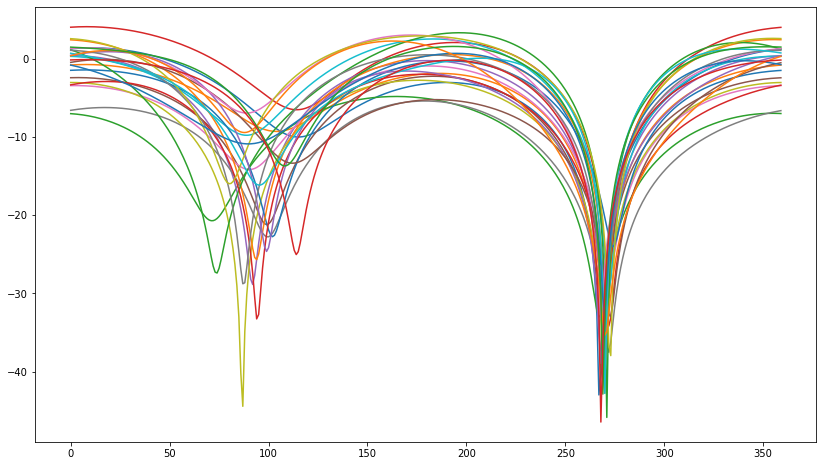

In [5]:
beamformer_obj = beamformer(mic=mic_array, frame_len=512)
beamout = beamformer_obj.compute_beampattern(mic_array, weights=w_n)
mesh(beamout[:, 2:-2].T)

plt.figure(figsize=(14, 8))
plt.plot(beamout[:, 8:32])
plt.show()


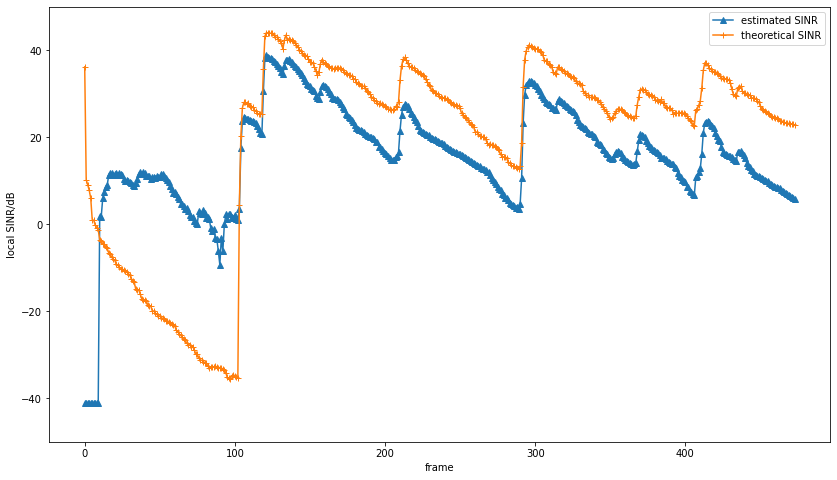

In [6]:
plt.figure(figsize=(14, 8))

plt.plot(librosa.power_to_db(xi[16,:]), marker="^")
plt.plot(librosa.power_to_db(xi_th[16,:]), marker="+")
plt.xlabel('frame')
plt.ylabel('local SINR/dB')
plt.ylim([-50,50])

plt.legend(['estimated SINR', 'theoretical SINR'])
plt.show()

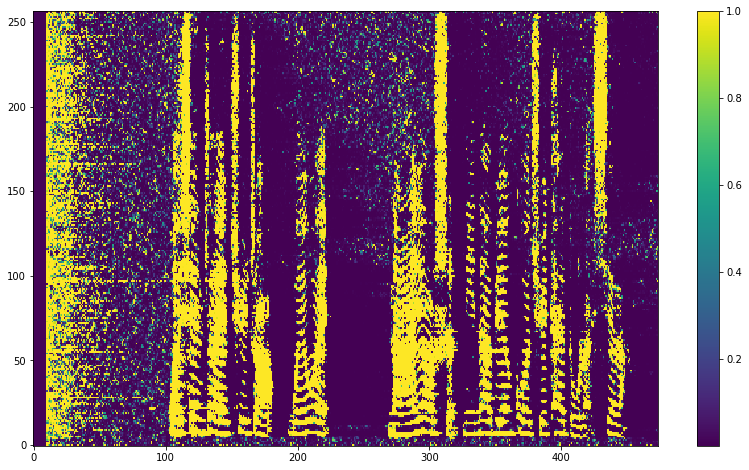

In [7]:
pmesh(p)

In [8]:
yout = transform.istft(Yout)
audiowrite('out1.wav', yout)